# <strong>STOR 515 Final Project</strong>
Fraud Detection Using Randomized Weighted Majority Algorithm\
Group 2:\
Zenan Ji\
Xinyue Xing\
William Li\
Zhan Lin

## Library importing and data loading

In [22]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv('../data/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## Data Processing

In [3]:
# check for null in each column
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [4]:
# check data types of each column
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

In [5]:
# convert the binary columns into Int type
num_cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
cat_cols = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
for col in cat_cols:
  df[col] = df[col].astype('int')

In [6]:
# check the statistics of each numerical column
df[num_cols].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182
std,65.390784,25.843093,2.799589
min,0.004874,0.000118,0.004399
25%,3.878008,0.296671,0.475673
50%,9.967760,0.998650,0.997717
75%,25.743985,3.355748,2.096370
max,10632.723672,11851.104565,267.802942


<Axes: xlabel='Fraud or Not', ylabel='Count'>

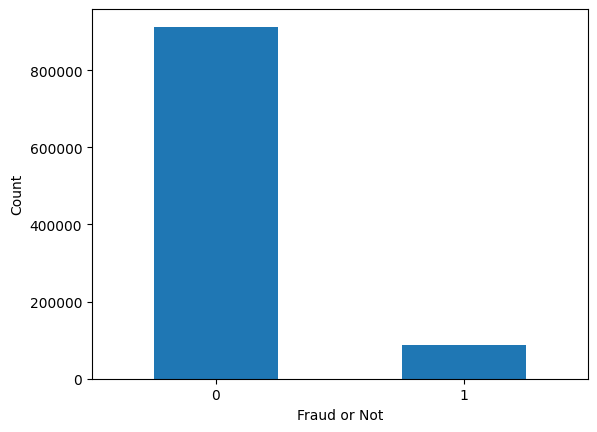

In [7]:
df['fraud'].value_counts().plot(kind='bar', ylabel='Count', rot=0, xlabel = 'Fraud or Not')

The bar chart shows that the dataset is extremely imbalanced, so we should be aware to apply techniques like upsampling or downsampling when training and testing our models

## Model (expert) Training

In [8]:
# list the continuous and discrete features
cont_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
discrete_features = list(set(cat_cols) - set(['fraud']))

non_fraud = df[df['fraud'] == 0]
is_fraud = df[df['fraud'] == 1]

# downsample the dataset to ensure balance
non_fraud_downsample = resample(non_fraud,
             replace=True,
             n_samples=len(is_fraud),
             random_state=42)
df_downsampled = pd.concat([is_fraud, non_fraud_downsample])

scaler = RobustScaler()

# turn dataset into matrices to be fed to the models
X_cont = df_downsampled[cont_features].values
X_disc = df_downsampled[discrete_features].values

X = np.concatenate((X_cont, X_disc), axis = 1)
y = df_downsampled['fraud'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .7)

# normalize the numerical features to fit the models
X_train[:, 0:3] = scaler.fit_transform(X_train[:, 0:3])
X_test[:, 0:3]= scaler.fit_transform(X_test[:, 0:3])

### Logistic Regression

In [9]:
# initialize the model
lr = LogisticRegressionCV()

lr.fit(X_train, y_train)

LogisticRegressionCV()

In [219]:
y_pred_probs = lr.predict_proba(X_test)[:,1]

y_lr_pred = y_pred_probs >= 0.5

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_lr_pred)))
print(classification_report(y_test, y_lr_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.9422
              precision    recall  f1-score   support

   Non fraud     0.9503    0.9331    0.9416     26211
       Fraud     0.9343    0.9513    0.9427     26231

    accuracy                         0.9422     52442
   macro avg     0.9423    0.9422    0.9422     52442
weighted avg     0.9423    0.9422    0.9422     52442



### Naive Bayes

In [11]:
# initialize the model
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB()

In [218]:
y_pred_probs = nb.predict_proba(X_test)[:,1]

y_nb_pred = y_pred_probs >= 0.5

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_nb_pred)))
print(classification_report(y_test, y_nb_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.9374
              precision    recall  f1-score   support

   Non fraud     0.9623    0.9105    0.9357     26211
       Fraud     0.9151    0.9644    0.9391     26231

    accuracy                         0.9374     52442
   macro avg     0.9387    0.9374    0.9374     52442
weighted avg     0.9387    0.9374    0.9374     52442



### Linear SVM with SGD training

In [13]:
# initialize the model
sgd = SGDClassifier(loss = 'hinge', penalty = 'l2', max_iter = 200)

sgd.fit(X_train, y_train)

SGDClassifier(max_iter=200)

In [217]:
y_sgd_pred = sgd.predict(X_test)

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_sgd_pred)))
print(classification_report(y_test, y_sgd_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.9383
              precision    recall  f1-score   support

   Non fraud     0.9439    0.9319    0.9378     26211
       Fraud     0.9328    0.9446    0.9387     26231

    accuracy                         0.9383     52442
   macro avg     0.9383    0.9383    0.9383     52442
weighted avg     0.9383    0.9383    0.9383     52442



### Decision Tree

In [15]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [162]:
# View performance of model
y_pred_probs = clf.predict_proba(X_test)[:,1]

y_train_pred_probs = clf.predict_proba(X_train)[:,1]

y_clf_pred = y_pred_probs >= 0.5

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_clf_pred)))
print(classification_report(y_test, y_clf_pred, target_names =['Non default', 'Default'], digits = 4))

Accuracy: 0.9968
              precision    recall  f1-score   support

 Non default     0.9937    1.0000    0.9968     26211
     Default     1.0000    0.9937    0.9968     26231

    accuracy                         0.9968     52442
   macro avg     0.9969    0.9968    0.9968     52442
weighted avg     0.9969    0.9968    0.9968     52442



### K-Nearest Neighbors

In [230]:
knn = KNeighborsClassifier(n_neighbors = 4)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [231]:
y_pred_probs = knn.predict_proba(X_test)[:,1]

y_knn_pred = y_pred_probs >= 0.5

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_knn_pred)))
print(classification_report(y_test, y_knn_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.9907
              precision    recall  f1-score   support

   Non fraud     0.9984    0.9829    0.9906     26211
       Fraud     0.9831    0.9985    0.9908     26231

    accuracy                         0.9907     52442
   macro avg     0.9908    0.9907    0.9907     52442
weighted avg     0.9908    0.9907    0.9907     52442



### "Dumb" Experts

In [19]:
# constantly predicting True/False
class DumbGuesser:
    def __init__(self, guess = False):
        self.guess = guess
    def predict(self):
        return self.guess


class RandomGuesser:
    def __init__(self):
        self.rand = np.random
    def predict(self):
        return self.rand.rand() >= 0.5

In [20]:
dbgt = DumbGuesser(True)
dbgt.predict()
dbgf = DumbGuesser()
dbgf.predict()
rdg = RandomGuesser()

## Baseline Method:
### WMA and RWM directly predicting y_test

In [206]:
# numbers of experts, rounds, mistakes
N = 8
T = len(y_test)

# lists for storing expert predictions and our predictions
yhat = []
expert_y = [ [] for i in range(N) ]

# picking a practical value for epsilon to be used in both algorithms
epsilon = (np.log(N)/T)**(1/2)

# reading in expert predictions and actual y
expert_y[0] = lr.predict(X_test)
expert_y[1] = nb.predict(X_test)
expert_y[2] = sgd.predict(X_test)
expert_y[3] = clf.predict(X_test)
expert_y[4] = knn.predict(X_test)
for i in range(len(X_test)):
	expert_y[5].append(int(dbgt.predict()))
	expert_y[6].append(int(dbgt.predict()))
	expert_y[7].append(int(rdg.predict()))


In [207]:
# WMA
wma_mistakes = 0

expert_mistakes = [ 0 for i in range(N) ]

# initializing weights
w = [ 1 for i in range(N) ]

for t in range(T):
	
	W = sum(w)
	wf = 0
	for i in range(N):
		wf += w[i]*expert_y[i][t]
	if wf/W >=0.5:
		yhat.append(1)
	else:
		yhat.append(0)
	# checking if the prediction is right
	if yhat[t] != y_test[t]:
		wma_mistakes = wma_mistakes + 1
	# updating expert weights and count mistakes
	for i in range(N):
		if expert_y[i][t] != y_test[t]:
			w[i] = w[i]*(1-epsilon)
			expert_mistakes[i] = expert_mistakes[i] + 1

print("Final weights: {}".format(w))
print("Total mistakes made by WMA: {}".format(wma_mistakes))
wma_accuracy = (T-wma_mistakes)/T
print("WMA accuracy:{}".format(wma_accuracy))

Final weights: [4.808540950768944e-09, 9.97486192985751e-10, 1.3087993267574909e-09, 0.35042551156339935, 0.0640650698520032, 1.238114808371126e-72, 1.238114808371126e-72, 2.779175858027444e-72]
Total mistakes made by WMA: 220
WMA accuracy:0.9958048892109378


In [202]:
# RWM
rwm_mistakes = []
# number of times to run it
K=100

for k in range(K):
	# reset weights, add mistake counter before starting
	w = [ 1 for i in range(N) ]
	rwm_mistakes.append(0)

	# moving through rounds, making predictions and updating weights as necessary
	for t in range(T):
		# calculating collective weight of all experts
		W = sum(w)
		# setting up probability distribution for picking expert
		expert_probs = []
		for i in range(N):
			expert_probs.append(w[i]/W)
		# randomly choosing an expert's prediction to use as your own
		chosen_expert = np.random.choice(N, 1, p=expert_probs)
		# checking if that expert (and thus your prediction) was right
		if expert_y[chosen_expert[0]][t] != y_test[t]:
			rwm_mistakes[k] = rwm_mistakes[k] + 1
		# updating expert weights
		for i in range(N):
			if expert_y[i][t] != y_test[t]:
				w[i] = w[i]*(1-epsilon)

print("Expected mistakes made by RWM: {}".format(np.average(rwm_mistakes)))
rwm_accuracy = (T-np.average(rwm_mistakes))/T
print("Expected accuracy of RWM: {}".format(rwm_accuracy))

Expected mistakes made by RWM: 473.57
Expected accuracy of RWM: 0.9909696426528355


In [232]:
# Check accuracy of each expert
for i in expert_mistakes:
    print((T-i) / T)

0.9421837458525609
0.9374356431867588
0.9382555966591664
0.9968345982227985
0.9917051218488997
0.5001906868540483
0.5001906868540483
0.5026314785858663


### Sanity Check: Does the result match what we learnt in class?

For WMA:\
$M_T(WMA)\leq\frac{2ln(N)}{\epsilon}+2(1+\epsilon)M_T(i^*)$

In [210]:
Mi_star = (expert_y[np.argmin(expert_mistakes)] != y_test).sum()
Mi_star

166

In [211]:
wma_mistakes <= 2 * np.log(N) / epsilon + 2 * (1 + epsilon) * Mi_star

True

For RWM:\
$E[M_T(RWM)]\leq\frac{ln(N)}{\epsilon}+(1+\epsilon)M_T(i^*)$

In [212]:
np.average(rwm_mistakes) <= np.log(N) / epsilon + (1 + epsilon) * Mi_star

True

In [220]:
expert_mistakes

[3032, 3281, 3238, 166, 435, 26211, 26211, 26083]

In [225]:
26083/len(y_test)

0.49736852141413374

Looks like our results do match the upper bound statement made in class. Let's put all the outputs in a table.

| Method   |      Accuracy |  # of Mistakes |
|----------|:-------------:|------:|
| Logistic Regression |  94.22% | 3032 |
| Naive Bayes |  93.74%     |   3281 |
| SVM | 93.83% |    3238 |
| Decision Tree |  99.68%    | 166 |
| KNN |  99.17%    | 435 |
| Dumb Expert: True(False) | 50% | 26211 |
| Dumb Expert: Random | 49.73% | 26083 |
| <strong>WMA | <strong>99.58% | <strong>220 |
| <strong>RWM(Expected) | <strong>99.09% | <strong>473.57 |

As the table shows, Both WMA and RWM do a pretty good job in classifying whether a transaction is fraud, and they both perform slightly worse than the best expert (decision tree in this context), but are able to outperform almost all other experts. In a real-life setting, if a decision maker is hearing from multiple experts, he/she wouldn't know the "algorithm" each expert uses to produce their predictions, and this experiment shows that decision maker can do almost as good as the best expert he/she is hearing from using WMA/RWM.

### Can we potentially improve the performance of WMA?

Currently, the WMA algorithm is doing slightly worse than the best expert. Can we modify the algorithm to make it perform better/closer to the best expert? Suppose the decision maker is confident in actively following the best expert so far, the algorithm can be modified by giving more penalty to the experts who make mistake and adding a step of incrementing the weight of the currently observed best expert at each iteration. We check if this would make the algorithm perform better.

In [235]:
# numbers of experts, rounds, mistakes
N = 8
T = len(y_test)
wma_mistakes = 0
rwm_mistakes = []
expert_mistakes = [ 0 for i in range(N) ]

# lists for storing expert predictions and our predictions
yhat = []
expert_y = [ [] for i in range(N) ]

# picking a practical value for epsilon to be used in both algorithms
epsilon = (np.log(N)/T)**(1/2)

# reading in expert predictions and actual y
expert_y[0] = lr.predict(X_test)
expert_y[1] = nb.predict(X_test)
expert_y[2] = sgd.predict(X_test)
expert_y[3] = clf.predict(X_test)
expert_y[4] = knn.predict(X_test)
for i in range(len(X_test)):
	expert_y[5].append(int(dbgt.predict()))
	expert_y[6].append(int(dbgt.predict()))
	expert_y[7].append(int(rdg.predict()))
	

w = [ 1 for i in range(N) ]


for t in range(T):
	
	W = sum(w)
	wf = 0
	for i in range(N):
		wf += w[i]*expert_y[i][t]
	if wf/W >=0.5:
		yhat.append(1)
	else:
		yhat.append(0)
	# checking if the prediction is right
	if yhat[t] != y_test[t]:
		wma_mistakes = wma_mistakes + 1
	# updating expert weights and count mistakes
	for i in range(N):
		if expert_y[i][t] != y_test[t]:
			w[i] = w[i]*(1-2 * epsilon)
			expert_mistakes[i] = expert_mistakes[i] + 1
		# For each expert that was correct, if it is the best one so far, add its weight
		else:
			if i == np.argmin(expert_mistakes):
				w[i] = w[i] * (1 + 2 * epsilon)
print("Modified WMA mistakes: {}".format(wma_mistakes))
wma_accuracy = (T-wma_mistakes)/T
print("Modified WMA accuracy: {}".format((wma_accuracy)))

Modified WMA mistakes: 173
Modified WMA accuracy: 0.9967011174249647


The modified WMA still doesn't outperform the best expert, but is pretty close. It reduced the number of mistakes of the algorithm by almost 60 and made only 7 more mistakes than the best expert. Although this modification works in this scenario, we don't think it would always work, especially when the best expert is actually learning while the data is being provided (making more mistakes at the start of the algorithm)

## Studying the Influence of "Noise"

We're also interested in learning the potential influence of noise(additional "dumb" experts). We first build a list of 105 experts containing the 5 "smart" experts (ML models) and 100 "dumb" experts (random guessers)

In [241]:
# numbers of experts, rounds, mistakes
N = 105
T = len(y_test)
wma_mistakes = 0
rwm_mistakes = []
expert_mistakes = [ 0 for i in range(N) ]

# lists for storing expert predictions and our predictions
yhat = []
expert_y = [ [] for i in range(N) ]

# picking a practical value for epsilon to be used in both algorithms
epsilon = (np.log(N)/T)**(1/2)

# reading in expert predictions and actual y
expert_y[0] = lr.predict(X_test)
expert_y[1] = nb.predict(X_test)
expert_y[2] = sgd.predict(X_test)
expert_y[3] = clf.predict(X_test)
expert_y[4] = knn.predict(X_test)
for i in range(len(X_test)):
	for j in range(5, 105):
		expert_y[j].append(rdg.predict())

We test the effect of noise on WMA first.

In [242]:
def test_WMA(experts_y, T):
    mistakes = []
    for i in range(5, 106, 20):
        N = i
        expert_mistakes = [ 0 for i in range(N) ]
        wma_mistakes = 0
        cumul_mistakes = []
        exp_y = experts_y[:i]
        yhat = []
        w = [ 1 for i in range(N) ]
        for t in range(T):
            W = sum(w)
            wf = 0
            for i in range(N):
                wf += w[i]*exp_y[i][t]
            if wf/W >=0.5:
                yhat.append(1)
            else:
                yhat.append(0)
            # checking if the prediction is right
            if yhat[t] != y_test[t]:
                wma_mistakes = wma_mistakes + 1
            # updating expert weights and count mistakes
            for i in range(N):
                if exp_y[i][t] != y_test[t]:
                    w[i] = w[i]*(1-epsilon)
                    expert_mistakes[i] = expert_mistakes[i] + 1
            cumul_mistakes.append(wma_mistakes)
        plt.plot(cumul_mistakes, label = f'{N-5} dumb experts')
        mistakes.append(wma_mistakes)
    plt.legend()
    plt.show()
    return mistakes

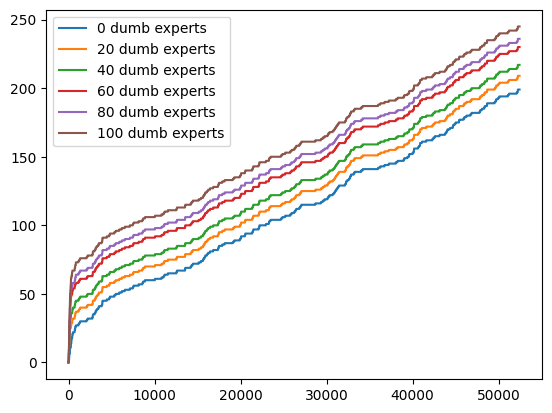

[199, 209, 217, 230, 236, 245]


In [243]:
print(test_WMA(expert_y, len(y_test)))

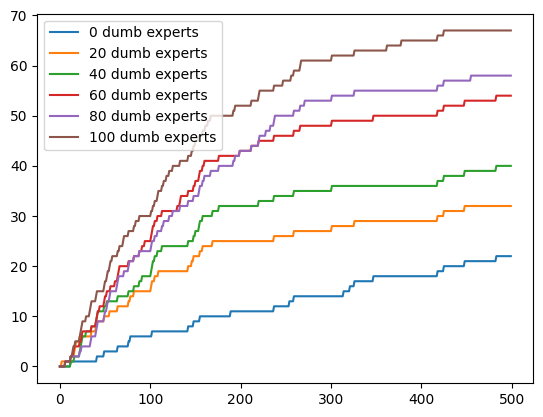

[22, 32, 40, 54, 58, 67]


In [248]:
print(test_WMA(expert_y, 500))

The plot shows that the trend of the experts making mistakes are almost the same, but the more noise there are, the more mistakes the algorithm tends to make at the beginning of the algorithm, ultimately leading to more overall mistakes.

In [113]:
def test_rwm(experts_y):
	T = len(y_test)
	exp_mistakes = []
	for i in range(5, 106, 20):
		exp_y = experts_y[:i]
		N = i
		rwm_mistakes = []
		K = 100
		for k in range(K):
			# reset weights, add mistake counter before starting
			w = [ 1 for i in range(N) ]
			rwm_mistakes.append(0)

			# moving through rounds, making predictions and updating weights as necessary
			for t in range(T):
				# calculating collective weight of all experts
				W = sum(w)
				# setting up probability distribution for picking expert
				expert_probs = []
				for i in range(N):
					expert_probs.append(w[i]/W)
				# randomly choosing an expert's prediction to use as your own
				chosen_expert = np.random.choice(N, 1, p=expert_probs)
				# checking if that expert (and thus your prediction) was right
				if exp_y[chosen_expert[0]][t] != y_test[t]:
					rwm_mistakes[k] = rwm_mistakes[k] + 1
				# updating expert weights
				for i in range(N):
					if exp_y[i][t] != y_test[t]:
						w[i] = w[i]*(1-epsilon)
		exp_mistakes.append(np.mean(rwm_mistakes))
	return exp_mistakes

In [114]:
expected_mistakes = test_rwm(expert_y)
expected_mistakes

[328.55, 498.2, 564.95, 598.35, 624.65, 649.6]

In [147]:
num_experts = [5, 25, 45, 65, 85, 105]
num_noise = ['0', '20', '40', '60', '80', '100']

In [129]:
# mistakes made by the best expert
Mi_star = (expert_y[3] != y_test).sum()

In [140]:
# check for upper bound
expected_mistakes <= (np.log(num_experts) / epsilon + (1 + epsilon) * Mi_star)

array([ True,  True,  True,  True,  True,  True])

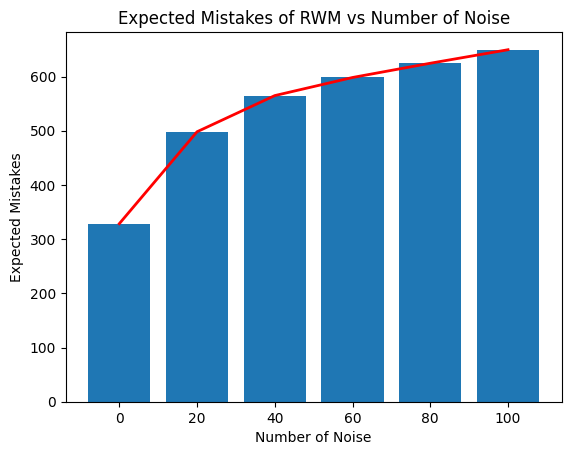

In [150]:
plt.bar(num_noise, expected_mistakes)
plt.xlabel('Number of Noise')
plt.ylabel('Expected Mistakes')
plt.title('Expected Mistakes of RWM vs Number of Noise')
plt.plot(num_noise, expected_mistakes, color = 'red', linewidth = 2)

Since RWM is a randomized algorithm, we don't plot its number of mistakes over time, but rather the expected mistakes for different number of noise in the experts. The plot shows that as the number of noise increases, the expected mistake of the algorithm also increases at a almost logarithmic rate. This makes sense because the number of mistakes made by the best expert is unchanged, adding noise would increase N, increasing expected mistakes at a $ln(N)$ rate.\
It is also noticable that the effect on mistakes for RWM is way larger than for WMA. With 100 noise, WMA made about 50 more mistakes while RWM was expected to make 300 more mistakes. This is probably because RWM is randomized, and adding more noise increase the total probability of any noise being selected.